In [108]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out


def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

**Training data**

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


**Test data**

In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# 1. What is the entropy  S0  of the initial system? 
df_train.Will_go.value_counts()

0    4
1    3
Name: Will_go, dtype: int64

In [14]:
s0 = -((3/7)*np.log2(3/7) + (4/7)*np.log2(4/7))
s0
# initial entropy is 0.98

0.9852281360342515

In [ ]:
# 2. Let's split the data by the feature "Looks_handsome". 
# What is the entropy  S1  of the left group - the one with "Looks_handsome". What is the entropy  S2  in the opposite group? 
# What is the information gain (IG) if we consider such a split?

In [13]:
df_train.iloc[:, :2]

,Will_go,Looks_handsome
0,0,1
1,1,1
2,0,1
3,1,0
4,1,0
5,0,0
6,0,1


In [21]:
s1 = -(1/4*np.log2(1/4) + 3/4*np.log2(3/4))
s2 = -(2/3*np.log2(2/3) + 1/3*np.log2(1/3))
info_gain = s0 - 4/7*s1 - 3/7*s2
np.round((s1, s2, info_gain), 4)

array([0.8113, 0.9183, 0.1281])

In [22]:
y = df_train.Will_go
X = df_train.drop('Will_go', axis=1)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X, y);

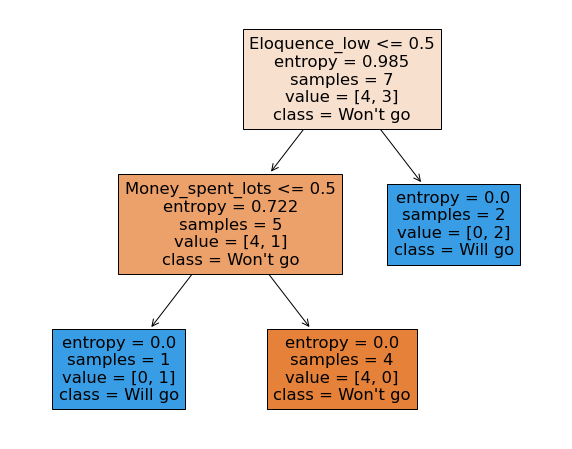

In [26]:
plot_tree(dt, feature_names=X.columns, filled=True,
         class_names=["Won't go", "Will go"]);

### Part 2. Functions for calculating entropy and information gain.

In [27]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [28]:
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

In [50]:
def entropy(a_list):
    a_list = list(a_list)
    size = len(a_list) 
    entropy = 0
    set_elements = len(set(a_list))
    if set_elements in [0, 1]:
        return 0
    for i in set(a_list):
        i_count = a_list.count(i)
        entropy -= i_count/size * np.log2(i_count/size)
    return round(entropy, 4)

In [51]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9928
0.9612
0.5917
2.585


In [46]:
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
    size = len(root)
    s0 = entropy(root)
    s1 = entropy(left)
    s2 = entropy(right)
    info_gain = s0 - len(left)/size * s1 - len(right)/size * s2
    return round(info_gain, 4)

In [47]:
# information gain from splitting the initial dataset into balls_left and balls_right 
information_gain(balls, balls_left, balls_right)

0.1609

In [84]:
def best_feature_to_split(X, y):
    '''Outputs information gain when splitting on best feature'''
    i_gains = []
    for i in X.columns:
        i_gains.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    best_id = i_gains.index(max(i_gains))
    best_feature = X.columns[best_id]
    print('Best feature to split: ' + best_feature)
    
    x_left = X[X.iloc[:, best_id] == 0]
    x_right = X[X.iloc[:, best_id] == 1]
    print('Size of left tree: {}'.format(len(x_left)))
    print('Size of right tree: {}'.format(len(x_right)))
    
    y_left = y[X.iloc[:, best_id] == 0]
    y_right = y[X.iloc[:, best_id] == 1]
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    print('Entropy: left {}, right {}'.format(entropy_left, entropy_right), end='\n\n')
    
    # recursion call
    if entropy_left != 0.:
        best_feature_to_split(x_left, y_left)
    elif entropy_right != 0.:
        best_feature_to_split(x_right, y_right)
    else:
        print('End splitting a tree.')

In [85]:
best_feature_to_split(X, y)
# similar to tree from using sklearn

Best feature to split: Eloquence_low
Size of left tree: 5
Size of right tree: 2
Entropy: left 0.7219, right 0

Best feature to split: Money_spent_little
Size of left tree: 4
Size of right tree: 1
Entropy: left 0, right 0

End splitting a tree.


### Part 3. The "Adult" dataset

In [87]:
%cd C:\Users\masha\Downloads

C:\Users\masha\Downloads


In [89]:
data_train = pd.read_csv('adult_train.csv')

In [90]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [92]:
data_test = pd.read_csv('adult_test.csv')
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [98]:
data_test.Target.unique()

array([nan, ' <=50K.', ' >50K.'], dtype=object)

In [99]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [103]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

In [105]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [106]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

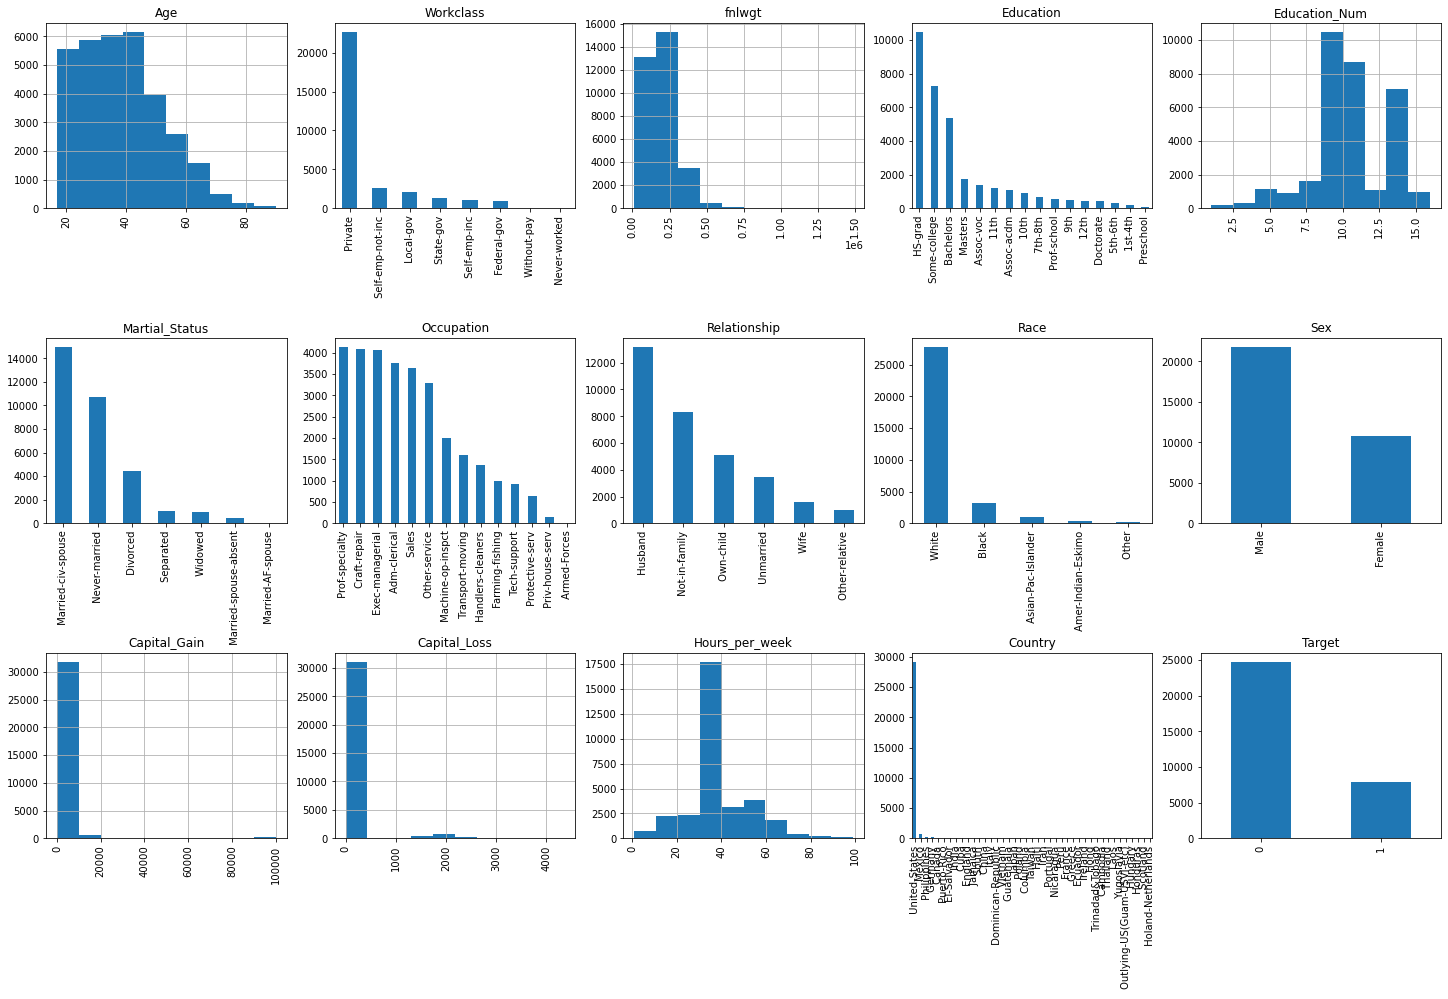

In [109]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [110]:
data_test['Age'] = data_test['Age'].astype(int)
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [111]:
categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

In [112]:
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [113]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [114]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [122]:
data_test['Country_ Holand-Netherlands'] = 0

**Train and make predictions using Decision tress**

In [123]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [124]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [125]:
tree_preds = tree.predict(X_test) 
accuracy_score(y_test, tree_preds)

0.8447884036607088

In [129]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5) # you code here                     
locally_best_tree.fit(X_train, y_train);

In [130]:
locally_best_tree.best_params_, locally_best_tree.best_score_

({'max_depth': 9}, 0.8565770273854106)

In [133]:
tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tree.fit(X_train, y_train)
tree_preds = tree.predict(X_test)
accuracy_score(y_test, tree_preds)

0.847798046803022

**Random Forest with tuning**

In [134]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [135]:
rf_preds = rf.predict(X_test) 
accuracy_score(y_test, rf_preds)

0.8585467723112831

In [136]:
rf_params = {'max_depth': range(10, 16),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(n_estimators=10, random_state=17),
    rf_params, cv=5)
locally_best_forest.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=10, random_state=17),
             param_grid={'max_depth': range(10, 16),
                         'max_features': range(5, 105, 20)})

In [137]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 13, 'max_features': 85}, 0.8621051461620324)

In [138]:
rf_preds = locally_best_forest.predict(X_test) 
accuracy_score(y_test, rf_preds)

0.8620477857625453